<a href="https://colab.research.google.com/github/greyhound101/shopee/blob/main/swa_lrs_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
class stocasticensembling():
  def __init__(self):
    #save_se_weights: save after each epoch ?

    self.lr_start   = 0.000001
    self.lr_max     = 0.000005 * 128
    self.lr_min     = 0.000001
    self.lr_ramp_ep = 5
    self.lr_sus_ep  = 0
    self.model_count = 0
    self.clr_iterations = 0
    self.lr_decay   = 0.8
    self.cycle_len=2
    self.swa_cycle_start_inx=15
    self.iter_per_epoch=108
    self.alpha1=alpha1=lr_min
    self.iter_per_cycle = self.cycle_len * self.iter_per_epoch
    self.alpha2=alpha2=lr_min*10
    self.cycle_num=0

  def on_train_end(self,logs={}):
    self.weight_update()
    self.model.set_weights(self.swa_weights)
    
  
  
  def on_epoch_end(self,epoch,logs=None):
    self.cycle_num+=1
    if (self._t_cycle() !=1) or (epoch<self.swa_cycle_start_inx):
      return
    self.model_count+=1
    print('updating for lr = '+str(self.lr)+' at epoch '+str(self.cycle_num))
  
  
  def on_batch_begin(self,batch,logs=None):
      self.clr_iterations+=1
      lr=self._clr_schedule()
      self.lr=lr
      return lr
  
  
  
  def weight_update(self):
    weights=self.model.get_weights()
    if self.model_count==0:
      self.swa_weights=weights
    for i in range(0,len(weights)):
      self.swa_weights[i]=(self.swa_weights[i]*self.model_count+weights[i])/(self.model_count+1)
  
  
  def _t_cycle(self):
        return (((self.clr_iterations - 1) % self.iter_per_cycle) + 1) / self.iter_per_cycle
  
  
  def _clr_schedule(self):
    if self.cycle_num>self.swa_cycle_start_inx:
      return ((1.0 - 1.0 *self._t_cycle()) * self.alpha2) + (1.0 *self._t_cycle() *self.alpha1)
    else:
      if self.cycle_num < self.lr_ramp_ep:
            lr = (self.lr_max - self.lr_start) / self.lr_ramp_ep * self.cycle_num + self.lr_start   
      elif self.cycle_num < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max    
      else:
            lr = (self.lr_max - self.lr_min) * self.lr_decay**(self.cycle_num - self.lr_ramp_ep - self.lr_sus_ep) + self.lr_min   
      return lr

In [96]:
cll=stocasticensembling()
ls=[]
for epoch in range(20):
  for itr in range(108):

    ls.append(cll.on_batch_begin(itr))
  cll.on_epoch_end(epoch)

updating for lr = 6.961210255360004e-05 at epoch 16
updating for lr = 1e-06 at epoch 18
updating for lr = 1e-06 at epoch 20


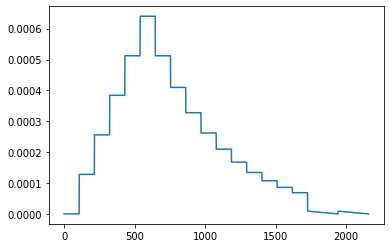

In [97]:
from matplotlib import pyplot as plt
plt.plot(ls)